In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import os
import csv

from Config import Config
from Models import KeypointDetectionModel, ConfidenceModel

/Users/julienstal/Library/Python/3.9/lib/python/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def split_data(data, test_size=0.2, random_seed=None):
    """
    Split dataset into train and test datasets. In our case, datasets are lists of dictionaries which
    contain entries: "Image Name", "x1", "y1", "x2", "y2"
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [4]:
"""
Create datasets by reading the csv files that contain the coordinates.
"""
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(f"{len(train_data)} training points and {len(test_data)} test points.")

1919 training points and 480 test points.


In [5]:
# Use "mps" to use GPU on macs ("cuda" on non-mac). "cpu" is slower. 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


In [6]:
"""
Create and train keypoint detection model. 
The KeypointDetection Model (KPD) takes images as inputs and learns to find the two points defining Weber's length.
Note: we keep track and restore the best performing version on the test dataset to avoid overfitting
"""
kpd_model = KeypointDetectionModel.KeypointDetectionModel().to(device)
KeypointDetectionModel.train_kpd_model(kpd_model, train_data, test_data, 50, 480, 801)

Epoch 0: test loss = 0.09615270793437958, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.004723269492387772, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.00342376995831728, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.0029933443292975426, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.0028043321799486876, lr = 1.326398781093821e-05
Epoch 250: test loss = 0.0027155682910233736, lr = 8.024793100055947e-06


KeyboardInterrupt: 

In [7]:
best_kpd_state = kpd_model.state_dict()

In [32]:
import Augment
from matplotlib import pyplot as plt
import imageProcessing

def get_original_image_pred(kpd_model, img_path, plot = False):
    pred = kpd_model(KeypointDetectionModel.get_input_tensor_from_image_path(img_path))
    y1pred, x1pred, y2pred, x2pred = pred[0][0].item() * Config.input_image_shape[0], pred[0][1].item() * Config.input_image_shape[1], pred[0][2].item() * Config.input_image_shape[0], pred[0][3].item() * Config.input_image_shape[1]

    base, _ = os.path.splitext(img_path)
    img_path = f"{base}.png"
    original_img = Augment.quad_channel_2_single_channel(img_path)
    original_shape = original_img.shape
    #print(original_shape)
        
    pt1, pt2 = (x1pred, y1pred), (x2pred, y2pred)
    points_before_transform = Augment.reverse_infer_keypoints([pt1, pt2], original_shape, Config.input_image_shape)
    p1, p2 = points_before_transform
    p1, p2 = p2, p1 # OOps
    if plot:

        print(points_before_transform)
        with_keypoints = imageProcessing.add_point_channels(original_img, p1, p2, radius=10)

        plt.plot()
        plt.imshow(with_keypoints)
        plt.show()
    
    return p1[0], p1[1], p2[0], p2[1]


[(726.8351113200188, 224.53148126602173), (486.88388952612877, 170.4034023284912)]


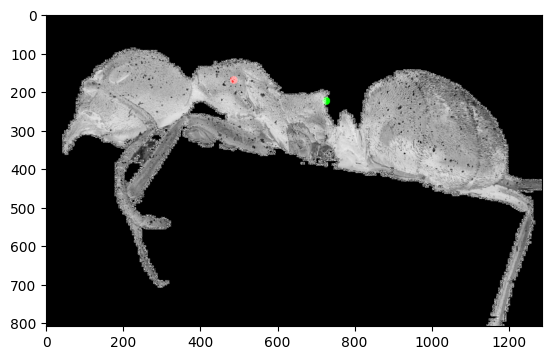

[(633.2602207660675, 211.12880873680115), (374.00589895248413, 170.83754563331604)]


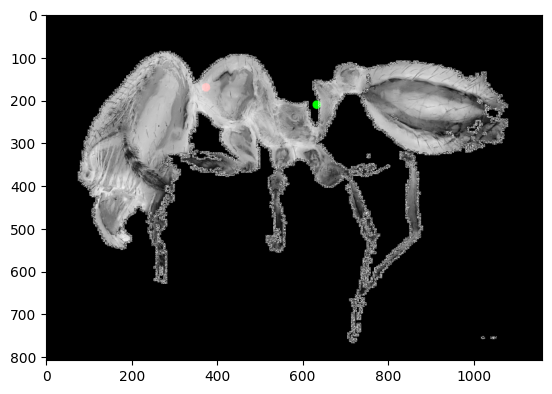

[(595.3467019796371, 183.05765986442566), (389.13854372501373, 185.86732244491577)]


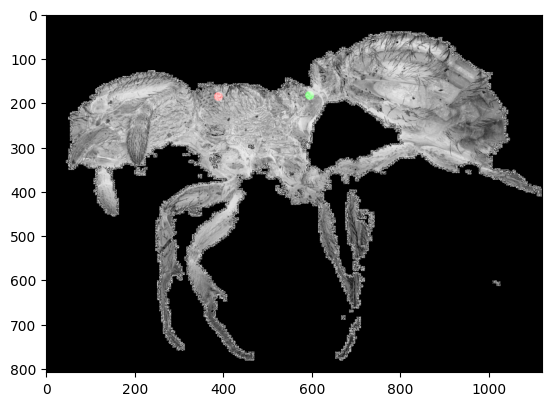

[(657.6435108184814, 177.64159631729126), (381.12102204561234, 152.5132257938385)]


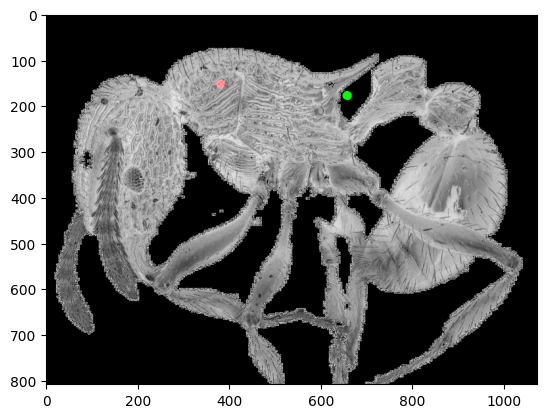

[(831.7474412918091, 256.77379155158997), (419.34120178222656, 148.74307322502136)]


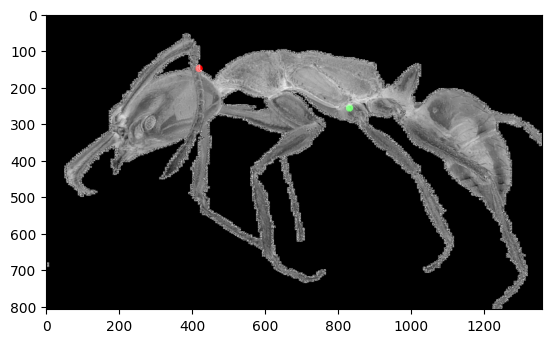

[(509.17303812503815, 271.3155574798584), (237.19199126958847, 132.08768510818481)]


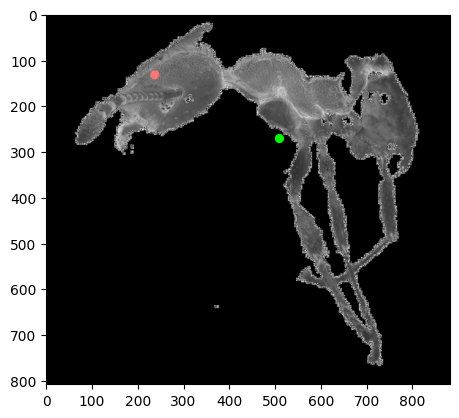

[(665.5277156829834, 240.81444382667542), (481.3678598403931, 199.06406044960022)]


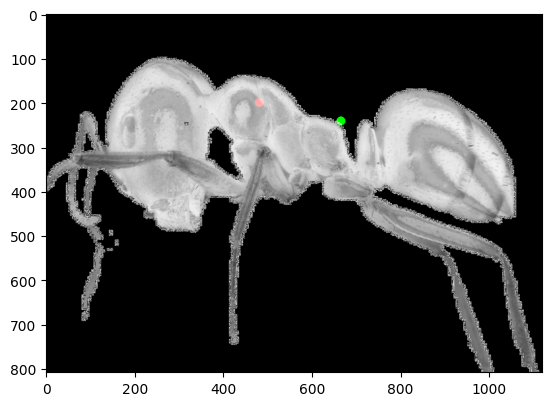

[(792.8768976926804, 255.5434820652008), (436.74521869421005, 163.64748811721802)]


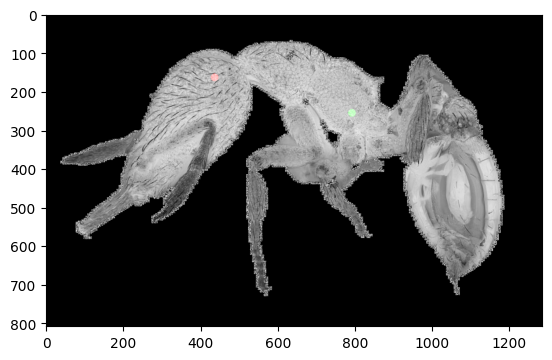

[(698.8385510444641, 240.86908197402954), (490.44217586517334, 193.95034885406494)]


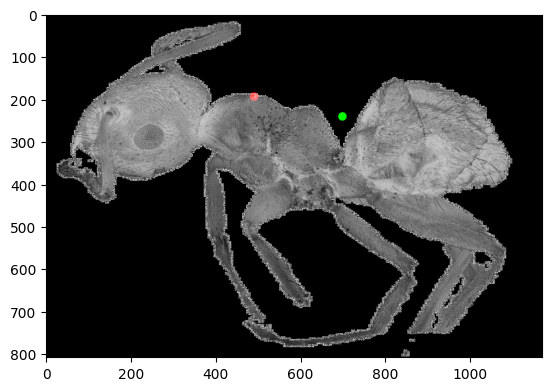

[(760.8303619027138, 274.05904746055603), (430.5499461889267, 150.39235544204712)]


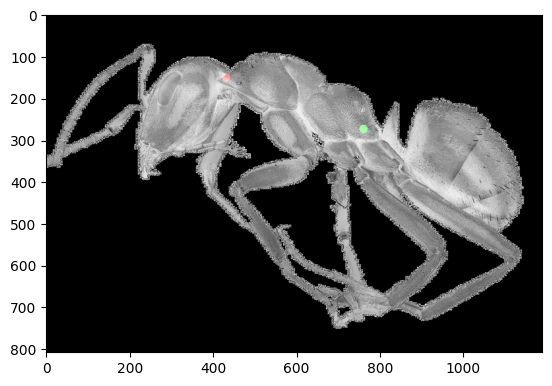

In [33]:
kpd_model.eval()

for point in train_data[:10]:
    name = "clean/"+point["Image Name"]
    get_original_image_pred(kpd_model, name, plot = True)

In [27]:
import os

def replace_jpg_with_png(directory):
    """
    Lists the names of the images in a given directory and replaces their 
    suffix by .png if they are .jpg.

    Args:
        directory (str): The path to the directory containing the images.

    Returns:
        list: A list of filenames with updated suffixes.
    """
    if not os.path.isdir(directory):
        raise ValueError(f"{directory} is not a valid directory")

    updated_filenames = []

    for filename in os.listdir(directory):
        if filename.lower().endswith('.jpg'):
            # Replace the suffix
            new_filename = os.path.splitext(filename)[0] + '.png'
            updated_filenames.append(new_filename)
        else:
            # Keep the filename as is
            updated_filenames.append(filename)

    return updated_filenames

In [28]:
image_names = replace_jpg_with_png("original")

In [29]:
print(image_names[:10])

['casent0132636_p_1.png', 'casent0282351_p_1.png', 'casent0179888_p_1.png', 'casent0911031_p_1.png', 'casent0903450_p_1.png', 'antweb1038578_p_1.png', 'casent0172857_p_1.png', 'casent0003131_p_1.png', 'antweb1008203_p_1.png', 'casent0217464_p_1.png']


In [34]:
pred_data = []
for image_name in image_names[:100]:
    pred = get_original_image_pred(kpd_model, "clean/"+image_name)
    pred_dict = {"Image Name": image_name, "x1": pred[0], "y1": pred[1], "x2": pred[2], "y2": pred[3]}
    pred_data.append(pred_dict)

In [35]:
print(pred_data)

[{'Image Name': 'casent0132636_p_1.png', 'x1': 461.4940165281296, 'y1': 201.0284571647644, 'x2': 655.5062655210495, 'y2': 243.30232167243958}, {'Image Name': 'casent0282351_p_1.png', 'x1': 429.72735196352005, 'y1': 183.94268226623535, 'x2': 654.66332924366, 'y2': 237.1618993282318}, {'Image Name': 'casent0179888_p_1.png', 'x1': 490.5111546218395, 'y1': 266.13025522232056, 'x2': 575.8722038269043, 'y2': 239.85229229927063}, {'Image Name': 'casent0911031_p_1.png', 'x1': 408.78079783916473, 'y1': 155.5892162322998, 'x2': 629.6739678382874, 'y2': 269.124059677124}, {'Image Name': 'casent0903450_p_1.png', 'x1': 534.6774831414223, 'y1': 200.22966623306274, 'x2': 891.0566344857216, 'y2': 255.95749425888062}, {'Image Name': 'antweb1038578_p_1.png', 'x1': 986.3321542739868, 'y1': 308.4790093898773, 'x2': 1067.1844954490662, 'y2': 292.41125226020813}, {'Image Name': 'casent0172857_p_1.png', 'x1': 522.5792611241341, 'y1': 287.22089314460754, 'x2': 581.3457198143005, 'y2': 210.57291555404663}, {'I

In [36]:
def dicts_to_csv(dict_list, output_file):
    """
    Writes a list of dictionaries to a CSV file.

    Args:
        dict_list (list): List of dictionaries with identical keys.
        output_file (str): Path to the output CSV file.

    Returns:
        None
    """
    if not dict_list:
        raise ValueError("The list of dictionaries is empty")

    # Extract headers from the first dictionary
    headers = dict_list[0].keys()

    with open(output_file, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        writer.writerows(dict_list)

In [37]:
dicts_to_csv(pred_data, "predictions.csv")